In [5]:
import pandas as pd
import numpy as np
import synapse
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass

@dataclass
class Cubic:
    # specify a cubic that passes through (0, 0) and (1, a)
    # with tangent at (0, 0) being m and tangent at (1, m) being n
    # can convert to a polynomial with
    # f(x) = (m+n-2a)x^3 + (3a-m-2n)x^2 + nx
    m: float
    n: float
    a: float

    def coeffs(self) -> tuple[float, float, float, float]:
        """Return the four polynomial coefficients (c3, c2, c1, c0)."""
        c3 = self.m + self.n - 2 * self.a
        c2 = 3 * self.a - 2 * self.m - self.n
        c1 = self.m
        c0 = 0.0
        return c3, c2, c1, c0
    
    def to_ndarray(self) -> np.ndarray:
        """Return the coefficients as a numpy array."""
        return np.array([self.m, self.n, self.a])

    def __call__(self, x):
        """Evaluate the cubic at x (scalar or array)."""
        c3, c2, c1, _ = self.coeffs()
        return ((c3 * x + c2) * x + c1) * x       # Horner form


def create_cubic_from_path(path: np.ndarray, overshoot_tol: float = 1e-3) -> Cubic:
    # path is shape [n, 2]; eg [(x1, y1), (x2, y2), ...]
    # returns a cubic that passes through (0, 0)
    # fit the best cubic to the path
    # points should be sorted

    # normalize the time to [0, 1]
    assert path.ndim == 2 and path.shape[1] == 2, "Path must be [n, 2]"

    x_vals = path[:, 0]
    assert np.all(np.diff(x_vals) >= 0), "Path x-coordinates must be sorted"

    # Translate so the first point is exactly (0, 0)
    path_shifted = path - path[0]

    # Independent variable: either the given x coordinates (if they vary)
    # or a uniform parameter if all x's are equal.
    x_raw = path_shifted[:, 0]
    x_raw = (x_raw - x_raw[0]) / (x_raw[-1] - x_raw[0])

    y = path_shifted[:, 1]
    a_target = y[-1]                              # y-value at x = 1

    # design matrix for coefficients [c3, c2, c1]
    X = np.column_stack((x_raw**3, x_raw**2, x_raw))

    # ------------------------------------------------------------------
    # Solve min ||X c − y||²  subject to  L c = b  where L = [1 1 1]
    # Use the KKT system:
    #       [XᵀX  Lᵀ] [c] = [Xᵀy]
    #       [ L    0 ] [λ]   [ b  ]
    # ------------------------------------------------------------------
    XtX = X.T @ X
    XtY = X.T @ y
    L   = np.array([[1.0, 1.0, 1.0]])
    b   = np.array([a_target])

    K   = np.block([[XtX, L.T],
                    [ L , np.zeros((1, 1))]])
    rhs = np.concatenate([XtY, b])

    sol = np.linalg.solve(K, rhs)
    c3, c2, c1 = sol[:3]                          # constrained LS solution

    # convert to (m, n, a)
    m = c1
    n = 3*c3 + 2*c2 + c1
    a = a_target

    return Cubic(m, n, a)

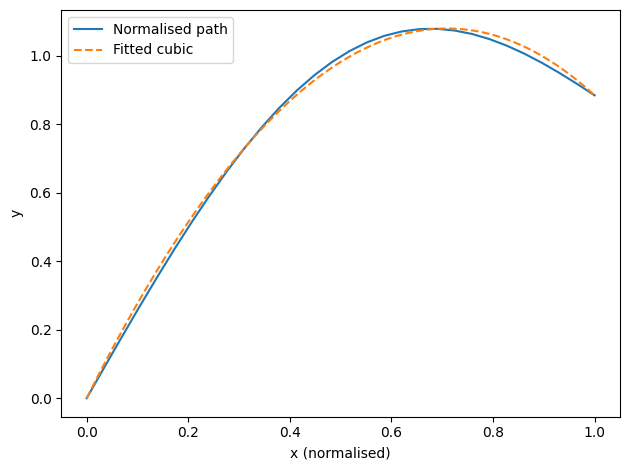

In [6]:
import matplotlib.pyplot as plt

t = np.linspace(0, 2, 30)
path = np.column_stack([t, 0.6*np.sin(1.5*t) + 0.4*t])

# normalise the original path
path_shifted = path - path[0]                       # shift to (0,0)
x_raw = path_shifted[:, 0]
x_norm = (x_raw - x_raw[0]) / (x_raw[-1] - x_raw[0])
path_norm = np.column_stack([x_norm, path_shifted[:, 1]])

cubic = create_cubic_from_path(path)

# plot
x_dense = np.linspace(0, 1, 400)
y_cubic = cubic(x_dense)

plt.figure()
plt.plot(path_norm[:, 0], path_norm[:, 1], label="Normalised path")
plt.plot(x_dense, y_cubic, "--", label="Fitted cubic")
plt.xlabel("x (normalised)")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
import json
from synapse import Action
import gcsfs

def get_all_action_logs(bucket_path: str):
    """Process files from GCS bucket."""
    fs = gcsfs.GCSFileSystem()

    # Remove gs:// prefix
    bucket_path = bucket_path[5:]

    try:
        files = fs.glob(f"{bucket_path}/action_capture_*.jsonl")
    except Exception as e:
        print(f"Error listing files from {bucket_path}: {e}")
        return

    all_actions = []

    for file_path in files:
        filename = file_path.split("/")[-1]

        try:
            with fs.open(file_path) as f:
                for line in f:
                    line = line.strip()
                    if line:
                        all_actions.append(Action(**json.loads(line)))
        except Exception as e:
            print(f"Error processing {filename}: {e}")
        
    return all_actions

In [8]:
import matplotlib.pyplot as plt
import copy
from importlib import reload
from synapse import Action, Scroll, MouseMove
from typing import Callable

def lerp_coordinate(t0: float, v0: float, t1: float, v1: float, t: float) -> float:
    """Linear interpolation helper (no clamping)."""
    if t1 == t0:
        return v0  # degenerate, shouldn't happen but stay safe
    return v0 + (v1 - v0) * ((t - t0) / (t1 - t0))

def fill_gaps(data: List[Action], step=0.033, fields=("x", "y")):
    new_data = []
    for i in range(len(data) - 1):
        curr = data[i]
        nxt = data[i + 1]
        new_data.append(curr)
        dt = nxt.timestamp - curr.timestamp
        if dt > step:
            n_steps = int(dt // step)
            for j in range(1, n_steps + 1):
                t = curr.timestamp + j * step
                if t < nxt.timestamp:
                    ratio = (t - curr.timestamp) / dt
                    current_data = Action(action=copy.copy(curr.action), timestamp=t)
                    for field in fields:
                        current_data.action.__setattr__(field, curr.action.__getattribute__(field) + ratio * (nxt.action.__getattribute__(field) - curr.action.__getattribute__(field)))
                    new_data.append(current_data)
    new_data.append(data[-1])
    return new_data

def process_continuous_actions(timestamps: np.ndarray, actions: List[Action], original_screen_size: Tuple[int, int], action_factory: Callable[[float, float], Action] = lambda x, y: MouseMove(x=x, y=y)) -> Tuple[List[Cubic], List[Cubic]]:
    timestamps = timestamps[1:]

    current_mouse_idx = 0

    poly_xs = []
    poly_ys = []

    for i, t_hi in enumerate(timestamps):
        current_mouse_move_buffer = []

        previous_mouse_move_idx = current_mouse_idx - 1
        while current_mouse_idx < len(actions) and actions[current_mouse_idx].timestamp <= t_hi:
            current_mouse_move_buffer.append(actions[current_mouse_idx])
            current_mouse_idx += 1
        
        next_mouse_move_idx = current_mouse_idx

        if current_mouse_idx >= len(actions):
            break

        # add two points at timestamps[i-1] and timestamps[1+1] exactly, by lerping
        # previous action and current action [0] for timestamps[i-1] 
        # next action and current action [-1] for timestamps[i+1]
        if i > 0 and previous_mouse_move_idx >= 0 and previous_mouse_move_idx + 1 < len(actions):
            t_lo = timestamps[i-1] if i > 0 else None
            previous_move = actions[previous_mouse_move_idx]
            previous_move_plus_one = actions[previous_mouse_move_idx + 1]
            x = lerp_coordinate(previous_move.timestamp, previous_move.action.x,
                                previous_move_plus_one.timestamp, previous_move_plus_one.action.x,
                                t_lo)
            y = lerp_coordinate(previous_move.timestamp, previous_move.action.y,
                                previous_move_plus_one.timestamp, previous_move_plus_one.action.y,
                                t_lo)

            first_event = Action(action=action_factory(float(x), float(y)), timestamp=t_lo)
            current_mouse_move_buffer.insert(0, first_event)
        
        if next_mouse_move_idx < len(actions):
            next_move = actions[next_mouse_move_idx]
            next_move_minus_one = actions[next_mouse_move_idx - 1]
            x = lerp_coordinate(next_move_minus_one.timestamp, next_move_minus_one.action.x,
                                next_move.timestamp, next_move.action.x,
                                t_hi)
            y = lerp_coordinate(next_move_minus_one.timestamp, next_move_minus_one.action.y,
                                next_move.timestamp, next_move.action.y,
                                t_hi)
            
            last_event = Action(action=action_factory(float(x), float(y)), timestamp=t_hi)
            current_mouse_move_buffer.append(last_event)

        if len(current_mouse_move_buffer) == 2:
            # put timestamp between and lerp
            in_between_timestamp = (current_mouse_move_buffer[0].timestamp + current_mouse_move_buffer[1].timestamp) / 2
            current_mouse_move_buffer.insert(1, Action(
                action=action_factory((current_mouse_move_buffer[0].action.x + current_mouse_move_buffer[1].action.x) / 2,
                                 (current_mouse_move_buffer[0].action.y + current_mouse_move_buffer[1].action.y) / 2),
                timestamp=in_between_timestamp
            ))
        
        mouse_x = np.array([(action.timestamp, action.action.x / original_screen_size[0]) for action in current_mouse_move_buffer])
        mouse_y = np.array([(action.timestamp, action.action.y / original_screen_size[1]) for action in current_mouse_move_buffer])

        tx = (mouse_x[:,0] - mouse_x[0,0]) / (mouse_x[-1,0] - mouse_x[0,0])
        yx = mouse_x[:,1] - mouse_x[0,1]

        ty = (mouse_y[:,0] - mouse_y[0,0]) / (mouse_y[-1,0] - mouse_y[0,0])
        yy = mouse_y[:,1] - mouse_y[0,1]
        
        poly_x = create_cubic_from_path(mouse_x)
        poly_y = create_cubic_from_path(mouse_y)

        # ax, cx = two_point_series_fit(tx, yx, N=10)   # quintic total degree
        # series_x = TwoPointSeries(ax, cx)

        # ay, cy = two_point_series_fit(ty, yy, N=10)
        # series_y = TwoPointSeries(ay, cy)

        poly_xs.append(poly_x)
        poly_ys.append(poly_y)
    
    return poly_xs, poly_ys 

In [ ]:
import cvxpy as cp
def clamp_slopes(m: float, n: float, a: float) -> Tuple[float, float]:
    if a == 0.0:
        return 0.0, 0.0
    limit = 3.0 * abs(a)
    sgn   = np.sign(a)
    m = 0.0 if np.sign(m) != sgn else np.clip(m, -limit, limit)
    n = 0.0 if np.sign(n) != sgn else np.clip(n, -limit, limit)
    return m, n

def create_cubic_from_path(path: np.ndarray,
                           lam: float = 0.1,
                           mu: float = 10.0,
                           delta: float = 1.0, 
                           objective: str = "mse") -> Cubic:
    """
    Fit a cubic f(t) to the points in *path* (shape [n,2]) where
    path[:,0] is time (monotone) and path[:,1] is y.

    Parameters
    ----------
    lam   : strength of curvature penalty      (OBJECTIVE = "curvature" or beyond)
    mu    : strength of soft overshoot barrier (OBJECTIVE = "overshoot")
    delta : Huber threshold                    (OBJECTIVE = "huber")

    Returns
    -------
    Cubic  – satisfies f(0)=0, f(1)=a  where a = path[-1,1]
    """
    # ---------------- basic checks + normalise time ------------------
    assert path.ndim == 2 and path.shape[1] == 2
    t_raw = path[:, 0]
    assert np.all(np.diff(t_raw) >= 0), "time must be sorted"

    # shift so first sample is (0,0);  normalise t to [0,1]
    y = path[:, 1] - path[0, 1]
    a = y[-1]                                 # f(1) target
    t = (t_raw - t_raw[0]) / (t_raw[-1] - t_raw[0])

    # column design matrix   X c = f(t)   with c = (c3,c2,c1)
    X = np.column_stack((t**3, t**2, t))
    ones_row = np.array([[1., 1., 1.]])       # for f(1) = a constraint

    # ----------------------------------------------------------------
    # 1)  PLAIN MSE  → closed form
    # ----------------------------------------------------------------
    if objective == "mse":
        K = np.block([[X.T @ X,            ones_row.T],
                      [ones_row,           [[0.]]]])
        rhs = np.concatenate([X.T @ y, [a]])
        c3, c2, c1 = np.linalg.solve(K, rhs)[:3]

    # ----------------------------------------------------------------
    # 2)  CURVATURE-REGULARISED MSE  (quadratic programme)
    # ----------------------------------------------------------------
    elif objective == "curvature":
        c = cp.Variable(3)                      # c3,c2,c1  (c0 is 0)
        pred = X @ c

        # integral_0^1 (f'')^2 dt = 12 c3^2 + 4 c2 c3 + 4 c2^2
        Q = np.array([[12, 2, 0],
                      [ 2, 4, 0],
                      [ 0, 0, 0]], float)

        obj = cp.sum_squares(pred - y) + lam * cp.quad_form(c, Q)
        prob = cp.Problem(cp.Minimize(obj), [cp.sum(c) == a])
        prob.solve()
        c3, c2, c1 = c.value

    # ----------------------------------------------------------------
    # 3)  SOFT OVERSHOOT BARRIER
    # ----------------------------------------------------------------
    elif objective == "overshoot":
        c = cp.Variable(3)
        pred = X @ c
        Q = np.array([[12, 2, 0], [2, 4, 0], [0, 0, 0]], float)

        ymax, ymin = y.max(), y.min()
        barrier = cp.sum_squares(cp.pos(pred - ymax)) \
                + cp.sum_squares(cp.pos(ymin - pred))
        obj = cp.sum_squares(pred - y) + lam * cp.quad_form(c, Q) + mu * barrier
        prob = cp.Problem(cp.Minimize(obj), [cp.sum(c) == a])
        prob.solve()
        c3, c2, c1 = c.value

    # ----------------------------------------------------------------
    # 4)  HUBER LOSS  (robust LS)
    # ----------------------------------------------------------------
    elif objective == "huber":
        c = cp.Variable(3)
        pred = X @ c
        Q = np.array([[12, 2, 0], [2, 4, 0], [0, 0, 0]], float)

        obj = cp.sum(cp.huber(pred - y, delta)) + lam * cp.quad_form(c, Q)
        prob = cp.Problem(cp.Minimize(obj), [cp.sum(c) == a])
        prob.solve()
        c3, c2, c1 = c.value

    # ----------------------------------------------------------------
    # 5)  ENDPOINT-WEIGHTED MSE
    # ----------------------------------------------------------------
    elif objective == "endpoint-weight":
        w = np.ones_like(y)
        w[[0, -1]] = 4.0                        # first & last  ×4
        W = np.diag(w)

        K = np.block([[X.T @ W @ X,             ones_row.T],
                      [ones_row,                [[0.]]]])
        rhs = np.concatenate([X.T @ W @ y, [a]])
        c3, c2, c1 = np.linalg.solve(K, rhs)[:3]

    else:
        raise ValueError(f"Unknown objective: {objective}")

    # --------------------------------------------------------------
    # convert to endpoint-slope form, clamp, rebuild coefficients
    # --------------------------------------------------------------
    m = c1
    n = 3 * c3 + 2 * c2 + c1
    # m, n = clamp_slopes(m, n, a)

    # keep f(1)=a exact after slope clamp
    c3 = m + n - 2 * a
    c2 = 3 * a - 2 * m - n

    return Cubic(m, n, a)

In [ ]:
import numpy as np
from numpy.polynomial.legendre import legval

def phi_basis(t, N):
    """
    Returns a (len(t) × (N-1)) matrix with columns phi_2 … phi_N evaluated at t.
    """
    T = 2*t - 1                    # map [0,1] → [-1,1]
    cols = []
    for k in range(2, N+1):
        Pk = legval(T, [0]*k + [1])    # fast Legendre k(T)
        cols.append(t*(1-t)*Pk)        # φ_k(t)
    return np.column_stack(cols)

def two_point_series_fit(t, y, N=5):
    """
    Fit y(t) with  t → a*t + Σ_{k=2}^N c_k φ_k(t)
    so f(0)=0, f(1)=a automatically.

    Parameters
    ----------
    t : array in [0,1]
    y : sample values
    N : highest order term to keep (total degree N)

    Returns
    -------
    a, c  where  f(t) = a*t + φ(t)·c
    """
    assert np.all((0.0 <= t) & (t <= 1.0)), "t must be normalised"
    a = y[-1]                         # enforce f(1)=a
    Φ = phi_basis(t, N)               # basis matrix
    rhs = y - a*t                     # move known part to RHS
    c, *_ = np.linalg.lstsq(Φ, rhs, rcond=None)
    return a, c

class TwoPointSeries:
    """Callable object for easy reuse."""
    def __init__(self, a, c):
        self.a = a
        self.c = c

    def __call__(self, t):
        φ = phi_basis(np.asarray(t), 1+len(self.c))   # rebuild basis on demand
        return self.a*t + φ @ self.c

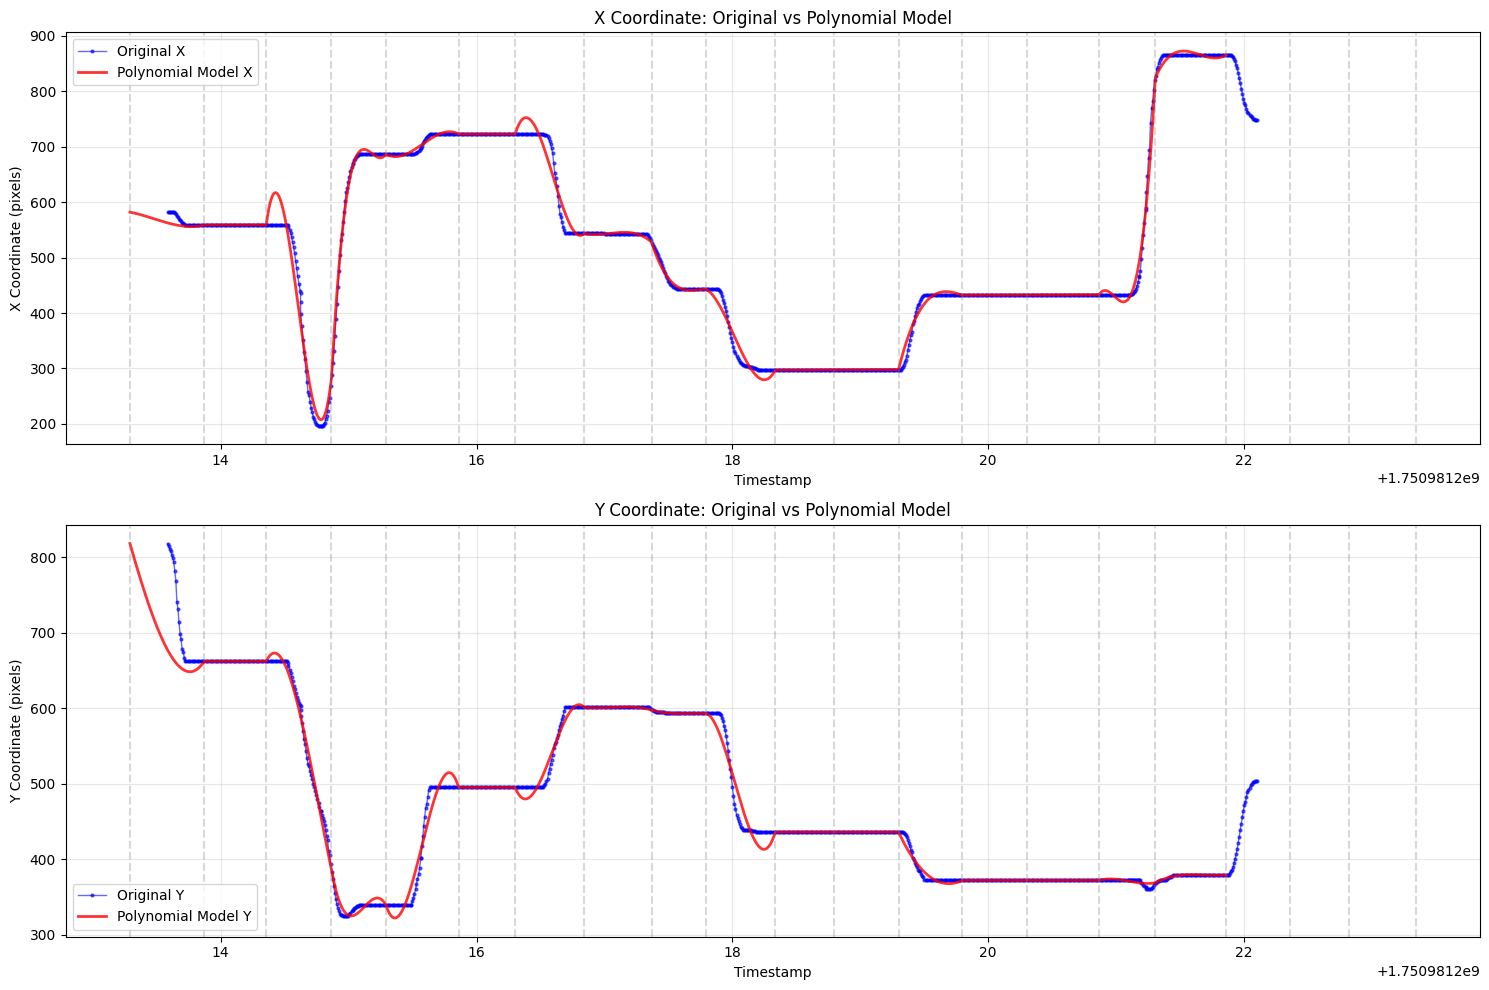

In [15]:
# Plot comparison of original timestamps vs polynomial modeled ones
import matplotlib.pyplot as plt

def plot_timestamp_comparison(timestamps, actions, poly_xs, poly_ys, original_screen_size):
    """Plot original timestamps vs polynomial modeled ones with continuous polynomials"""

    # Filter mouse move actions

    # Create subplots for x and y coordinates
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot all original data first
    orig_times_all = [action.timestamp for action in actions]
    orig_x_all = [action.action.x for action in actions]
    orig_y_all = [action.action.y for action in actions]

    ax1.plot(orig_times_all, orig_x_all, 'o-', alpha=0.6, markersize=2, linewidth=1,
            color='blue', label='Original X')
    ax2.plot(orig_times_all, orig_y_all, 'o-', alpha=0.6, markersize=2, linewidth=1,
            color='blue', label='Original Y')

    # Now build the continuous polynomial curve
    all_poly_times = []
    all_poly_x = []
    all_poly_y = []

    # Initialize previous last x and y coordinates
    previous_last_x = orig_x_all[0]
    previous_last_y = orig_y_all[0]
    for i, (poly_xs, poly_ys) in enumerate(zip(poly_xs, poly_ys)):
        # Generate dense x values for the polynomial
        x_dense = np.linspace(0, 1, 400)
        y_cubic_of_xcoord = poly_xs(x_dense)
        y_cubic_of_ycoord = poly_ys(x_dense)
        all_poly_times.extend(x_dense * (timestamps[i+1] - timestamps[i]) + timestamps[i])
        all_poly_x.extend(y_cubic_of_xcoord * original_screen_size[0] + previous_last_x)
        all_poly_y.extend(y_cubic_of_ycoord * original_screen_size[1] + previous_last_y)

        previous_last_x = all_poly_x[-1]
        previous_last_y = all_poly_y[-1]

    # Plot continuous polynomial curve
    if all_poly_times:
        ax1.plot(all_poly_times, all_poly_x, '-', color='red', linewidth=2,
                label='Polynomial Model X', alpha=0.8)
        ax2.plot(all_poly_times, all_poly_y, '-', color='red', linewidth=2,
                label='Polynomial Model Y', alpha=0.8)
    
    # draw lines at each timestamp
    for t in timestamps:
        ax1.axvline(t, color='gray', linestyle='--', alpha=0.3)
        ax2.axvline(t, color='gray', linestyle='--', alpha=0.3)

    # Format plots
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('X Coordinate (pixels)')
    ax1.set_title('X Coordinate: Original vs Polynomial Model')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.set_xlabel('Timestamp')
    ax2.set_ylabel('Y Coordinate (pixels)')
    ax2.set_title('Y Coordinate: Original vs Polynomial Model')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return [all_poly_times, all_poly_x, all_poly_y, orig_times_all, orig_x_all, orig_y_all]


# Generate the comparison plot
logs = get_all_action_logs("gs://induction-labs-data-ext/action_capture/jonathan/2025-06-26_164012_TG1MZ")

    
timestamps = np.arange(logs[0].timestamp-0.2, logs[-1].timestamp, 0.5)
# add some noise to timestamps
timestamps += np.random.uniform(-0.05, 0.05, size=timestamps.shape)

mouse_move_actions = [action for action in logs if isinstance(action.action, MouseMove)]
for action in mouse_move_actions:
    action.timestamp += 0.05

filled_actions = fill_gaps(mouse_move_actions, step=0.01)
states = process_continuous_actions(timestamps, filled_actions, (1440, 900))
t, x, y, treal, xreal, yreal = plot_timestamp_comparison(timestamps, filled_actions,
                        states[0], states[1], (1440, 900))

(325.0, 818.0)

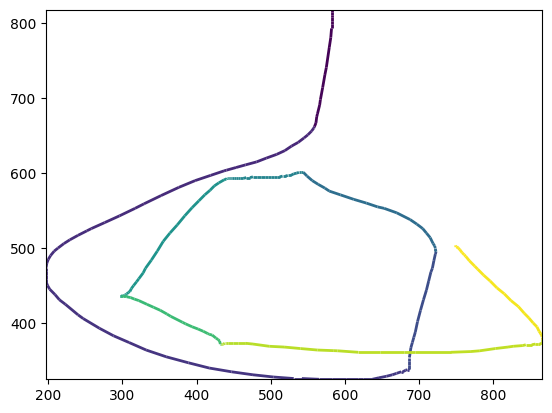

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm

t = np.array(treal)
x = np.array(xreal)
y = np.array(yreal)
norm = plt.Normalize(t.min(), t.max())
colors = cm.viridis(norm(t))

# Build segments between consecutive points
pts = np.stack([x, y], axis=1)
segs = np.concatenate([pts[:-1,None], pts[1:,None]], axis=1)

# Create a LineCollection, one segment per time step
lc = LineCollection(segs, colors=colors[:-1], linewidth=2)

fig, ax = plt.subplots()
ax.add_collection(lc)
ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y), max(y))

In [ ]:
reconstructed_actions = [
    Action(action=MouseMove(x=x_coord, y=y_coord), timestamp=timestamp).model_dump()
    for timestamp, x_coord, y_coord in zip(t, x, y)
]

In [99]:
with open("reconstructed_actions.jsonl", "w") as f:
    for action in reconstructed_actions:
        f.write(json.dumps(action) + "\n")